## Run KGC with LLM + Ontology

In [1]:
import os
import re
import json
import spacy
from openai import OpenAI
from dotenv import load_dotenv
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
api_key = os.getenv("API_KEY")
URI = os.getenv("URI_neo4j")
USER = os.getenv("USER_neo4j")
PASSWORD = os.getenv("PASSWORD_neo4j")

In [3]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

#### Run LLM function (chatgpt)

In [4]:
# models:
#   - gpt-3.5-turbo
#   - gpt-4
#   - gpt-4-turbo
#   - gpt-4o-mini
def query(prompt, model='gpt-4o-mini', temperature=0):
    client = OpenAI(api_key=api_key)

    res = client.chat.completions.create(
            model=model,
            temperature=temperature,
            messages=[
            {"role": "user", "content": prompt}
            ])
    return res

### Load Prompts and Ontology

In [5]:
#load json file
with open('Ontology/geo_ontology.json', 'r') as file:
    ontology = json.load(file)


# Load ontology entities and relations
entities_list = []
ontology_entities = ""
for concept in ontology["concepts"]:
    ontology_entities += f'{concept["label"]}, '
    entities_list.append(concept["label"])

ontology_entities = ontology_entities[:-2]
print(ontology_entities)

relations_list = []
ontology_relations_list = []
ontology_relations = ""
for relation in ontology["relations"]:
    ontology_relations += f'{relation["label"]}{relation["domain"], relation["range"]}, '
    relations_list.append(relation["label"])
    ontology_relations_list.append(relation)

print(ontology_relations)
print(entities_list)
print(relations_list)
print(ontology_relations_list)

print("___________________________________________________________________________________________________________")

# Generate prompt for LLM to extract triples from a sentence
def ontology_prompt(text, ontology_entities, ontology_relations, entities=None):

    prompt= f"""Given the following ontology and sentences, please extract the triples from the sentence according to the relations in the ontology. In the output, only include the triples in the given output format.

context:
Ontology Entities: {ontology_entities}
Ontology Relations: {ontology_relations}

Example Sentence: The stratigraphy of the area includes the Triassic Sandstone, which is approximately 250 Ma old and contains quartz and feldspar.
Example Output:
hasAge(Sandstone (Rock), Triassic (GeologicalTimescale))
hasAge(Sandstone (Rock), 250 Ma (GeologicalTimescale))
contains(Sandstone (Rock), quartz (Mineral))
contains(Sandstone (Rock), feldspar (Mineral))
"""
    
    if entities is not None:
        prompt += f"""
Now, using the following provided entities as a guide for which entities to find, extract triples for the sentence:
Provided entities:
{entities}
    """

    prompt += f"""
Test Sentence: {text}
Test Output:
    """

    return prompt


# Example
text = "Mapping and geochronology by the Geological Society of Australia (Arriens, 1971) reveal that the granitic rocks in the western part of the Yalgoo 1:250,000 map sheet are in the order of 2,800 to 3,000 Ma."
prompt = ontology_prompt(text, ontology_entities, ontology_relations)

print(prompt)

GeologicalTimescale, Location, Mineral, OreDeposit, Rock, Stratigraphy, Date
contains('Rock', 'Mineral'), contains('Mineral', 'OreDeposit'), contains('Stratigraphy', 'Rock'), contains('Rock', 'Rock'), foundIn('Rock', 'Location'), foundIn('Mineral', 'Location'), foundIn('OreDeposit', 'Location'), foundIn('Stratigraphy', 'Location'), foundAt('Rock', 'Date'), foundAt('Mineral', 'Date'), foundAt('OreDeposit', 'Date'), isPartOf('Stratigraphy', 'Stratigraphy'), underlies('Stratigraphy', 'Stratigraphy'), overlies('Stratigraphy', 'Stratigraphy'), hasAge('Rock', 'GeologicalTimescale'), hasAge('Mineral', 'GeologicalTimescale'), hasAge('OreDeposit', 'GeologicalTimescale'), hasAge('Stratigraphy', 'GeologicalTimescale'), LocatedIn('Location', 'Location'), locatedNear('Location', 'Location'), 
['GeologicalTimescale', 'Location', 'Mineral', 'OreDeposit', 'Rock', 'Stratigraphy', 'Date']
['contains', 'contains', 'contains', 'contains', 'foundIn', 'foundIn', 'foundIn', 'foundIn', 'foundAt', 'foundAt', '

Function to get Enitites From NER Results

In [6]:
convert_type = {"ROCK" : "Rock", "TIMESCALE" : "GeologicalTimescale", "MINERAL" : "Mineral", "LOCATION" : "Location", 
                "ORE_DEPOSIT": "OreDeposit", "STRAT": "Stratigraphy", "DATE": "Date"}

def get_entities(doc, iob_tags):
    entities = []
    current_entity = []
    current_tag = None
    for token, tag in zip(doc, iob_tags):
        if tag.startswith('B-'):
            if current_entity:
                # Save the previous entity before starting a new one
                entities.append((" ".join(current_entity), convert_type[current_tag]))
            # Start a new entity
            current_entity = [token]
            current_tag = tag.split('-')[1]  # Get the entity type (e.g., DATE, LOCATION)
        elif tag.startswith('I-') and current_tag == tag.split('-')[1]:
            # Continue the current entity
            current_entity.append(token)
        else:
            if current_entity:
                # If we reach an 'O' or unrelated tag, save the current entity
                entities.append((" ".join(current_entity), convert_type[current_tag]))
                current_entity = []
                current_tag = None

    # Catch any remaining entity at the end of the loop
    if current_entity:
        entities.append((" ".join(current_entity), current_tag))

    return entities

Load Reports and their NER Results

In [7]:
# load json file
with open("../Results/tagged_reports_combined_results.json", "r") as file:
    tagged_reports = json.load(file)

In [8]:
count = {"B-ROCK": 0, "I-ROCK": 0, "B-LOCATION": 0, "I-LOCATION": 0, "B-TIMESCALE": 0, "I-TIMESCALE": 0, "B-MINERAL": 0, "I-MINERAL": 0, 
         "B-ORE_DEPOSIT": 0, "I-ORE_DEPOSIT": 0, "B-STRAT": 0, "I-STRAT":0, "B-DATE" :0 , "I-DATE": 0}
num_of_sentences = 0
errors = 0
for report in tagged_reports:
    for a in tagged_reports[report]:
        num_of_sentences += 1
        tag = tagged_reports[report][a]["combined"].split()
        for s in tag:
            if 'O' != s:
                try:
                    count[s] += 1
                except:
                    print(s)
                    errors += 1

print(count)
print(errors)
print(num_of_sentences)

B-LOCATION-
B-IF
{'B-ROCK': 2837, 'I-ROCK': 627, 'B-LOCATION': 3789, 'I-LOCATION': 2071, 'B-TIMESCALE': 346, 'I-TIMESCALE': 90, 'B-MINERAL': 2611, 'I-MINERAL': 23, 'B-ORE_DEPOSIT': 410, 'I-ORE_DEPOSIT': 243, 'B-STRAT': 856, 'I-STRAT': 1074, 'B-DATE': 3115, 'I-DATE': 1963}
2
9447


### LLM Generation with Prompts

In [9]:
def extract_temporal_relations(tagged_reports):
    for report in tagged_reports:
        for sentence in tagged_reports[report]:
            doc = tagged_reports[report][sentence]["preprocess"].split()
            print(sentence)
            iob_tags = tagged_reports[report][sentence]["combined"].split(" ")

            if len(set(iob_tags)) > 1:
                entities = get_entities(doc, iob_tags)
                
                tagged_reports[report][sentence]["llm_results"] = None
                if entities:
                    entity_text = "\n".join([f"- {entity[0]} ({entity[1]})" for entity in entities])

                    prompt = ontology_prompt(sentence, ontology_entities, ontology_relations, entity_text)

                    results = query(prompt).choices[0].message.content.strip()
                    print(results)
                    tagged_reports[report][sentence]["llm_results"] = results
                print()
            else:
                # Text does not contain any entities
                tagged_reports[report][sentence]["llm_results"] = None
    return tagged_reports

# Perform relationship extraction using LLM (GPT-4o-mini) on the tagged reports
# Change the if statement to always run the function
if not os.path.exists("../Results/tagged_reports_combined_results.json"):
    tagged_reports = extract_temporal_relations(tagged_reports)

In [10]:
# # save the results
# with open("../Results/LLM_Ontology_NER.json", "w") as file:
#     json.dump(tagged_reports, file)

# Load the results
with open("../Results/LLM_Ontology_NER.json", "r") as file:
    all_tagged = json.load(file)

In [11]:
# Function to extract entities and relation from the input string and convert to knowledge graph triple
def parse_and_convert_to_kg_types(input_string):
    # Regular expression to extract the relation, head entity, head type, tail entity, and tail type
    pattern = r'(\w+)\(([^()]+)\s\((\w+)\),\s([^()]+)\s\((\w+)\)\)'
    match = re.match(pattern, input_string)
    
    if match:
        relation = match.group(1)
        head_entity = match.group(2).strip()
        head_type = match.group(3)
        tail_entity = match.group(4).strip()
        tail_type = match.group(5)
        
        # Return the extracted data as a triple
        return (head_entity, head_type, relation, tail_entity, tail_type)
    else:
        return None
    
# Function to insert the triple into the knowledge graph
def add_to_knowledge_graph(kg, triple):
    head_entity, head_type, relation, tail_entity, tail_type = triple
    # Add the relation and tail entity to the knowledge graph
    kg[(head_entity, head_type)][relation].add((tail_entity, tail_type))


# Input string
input_string = "foundIn(Rainy RocksE2 (Rock), 18 April 2011 (Location))"

# Convert to knowledge graph triple
kg_triple = parse_and_convert_to_kg_types(input_string)

# Print the result
if kg_triple:
    print(f"({kg_triple[0]} ({kg_triple[1]}), {kg_triple[2]}, {kg_triple[3]} ({kg_triple[4]}))")
else:
    print("Invalid format")

(Rainy RocksE2 (Rock), foundIn, 18 April 2011 (Location))


### Clean KG with Ontology

In [12]:
num_of_triples_llm = 0
num_of_cleaned_triples = 0

for reports in all_tagged:
    for sentence in all_tagged[reports]:
        all_tagged[reports][sentence]["ontology_cleaned"] = []
        if all_tagged[reports][sentence]["llm_results"]:
            triples = all_tagged[reports][sentence]["llm_results"].split("\n")

            for triple in triples:
                kg_triple = parse_and_convert_to_kg_types(triple)
                if kg_triple:
                    num_of_triples_llm += 1

                    for relation in ontology_relations_list:
                        if (kg_triple[2] == relation["label"] and kg_triple[1] == relation["domain"] 
                            and kg_triple[4] == relation["range"] 
                            and not (kg_triple[0] == kg_triple[3] and kg_triple[1] == kg_triple[4])):
                            all_tagged[reports][sentence]["ontology_cleaned"].append(kg_triple)
                            num_of_cleaned_triples += 1

print(num_of_triples_llm)
print(num_of_cleaned_triples)

15610
10804


### Clean KG with NER Results
- If both entities in a relation is not in tagged in NER, then triple is removed

In [13]:
count = 0

for reports in all_tagged:
    for sentence in all_tagged[reports]:
        all_tagged[reports][sentence]["ner_cleaned"] = []
        if all_tagged[reports][sentence]["ontology_cleaned"]:

            iob_tags = all_tagged[reports][sentence]["combined"].split()
            text = all_tagged[reports][sentence]["preprocess"].split()
            entities = set(get_entities(text, iob_tags)) # Get unique entities

            triples = all_tagged[reports][sentence]["ontology_cleaned"]
            for triple in triples:
                left_entity_types = []
                left_entitys = []
                right_entity_types = []
                right_entitys = []
                
                # Get the entity types for the head and tail entities, can have multiple types
                for entity in entities:
                    if (entity[0] in triple[0]) or (triple[0] in entity[0]):
                        left_entity_types.append(entity[1])
                        left_entitys.append(entity[0])
                    if (entity[0] in triple[3]) or (triple[3] in entity[0]):
                        right_entity_types.append(entity[1])
                        right_entitys.append(entity[0])
                # If the entity types for the head entity are not consistent, set to None
                # if any of the entities have their types changed, change the relation
                change_relation = False
                temp_list = list(triple)

                # If the entity types are not consistent, set to None
                if len(set(left_entity_types)) > 1:
                    if triple[0] in left_entitys:
                        left_entity_types = [entity[1] for entity in entities if entity[0] == triple[0]]
                    elif triple[1] in left_entity_types:
                        left_entity_types = [triple[1]]
                    else:
                        left_entity_types = None
                elif len(set(left_entity_types)) == 1 and triple[1] != left_entity_types[0] and (triple[0] in left_entitys or triple[1] == "Date" or triple[1] == "Timescale"):
                    left_entity_types = [triple[1]]
                    change_relation = True

                if len(set(right_entity_types)) > 1:
                    # If the Entity is a Timescale and Rock, remove the Timescale from the Rock entity
                    # and add a new triple with the Timescale
                    if "GeologicalTimescale" in right_entity_types and ("Rock" in right_entity_types):
                        timescale_index = right_entity_types.index("GeologicalTimescale")
                        
                        temp_list[3] = triple[3].replace(right_entitys[timescale_index], "").strip()
                        temp_list[4] = ["Rock"]
                        timescale_triple = (triple[3], right_entity_types[0], "hasAge", right_entitys[timescale_index], "GeologicalTimescale")
                        all_tagged[reports][sentence]["ner_cleaned"].append(timescale_triple)
                elif len(set(right_entity_types)) == 1 and triple[4] != right_entity_types[0] and (triple[3] in right_entitys or triple[4] == "Date" or triple[4] == "Timescale"):
                    temp_list[4] = right_entity_types[0]
                    change_relation = True

                # If the entity types are not consistent, change it based on the ontology
                if change_relation:
                    for relation in ontology_relations_list:
                        if (temp_list[1] == relation["domain"] and temp_list[4] == relation["range"]):
                            temp_list[2] = relation["label"]
                            break
                        # If the relation is reversed, swap the entities and change the relation
                        elif (temp_list[1] == relation["range"] and temp_list[4] == relation["domain"]):
                            temp_list[2] = relation["label"]
                            temp_list[0], temp_list[3] = temp_list[3], temp_list[0]
                            temp_list[1], temp_list[4] = temp_list[4], temp_list[1]
                            break
                triple = tuple(temp_list)
                
                if left_entity_types and right_entity_types and (triple[1] in left_entity_types) and (triple[4] in right_entity_types):
                    all_tagged[reports][sentence]["ner_cleaned"].append(triple)
                    count += 1

print(count)

4441


In [14]:
# # save model json results
# import json
# with open('model_kg.json', 'w') as f:
#     json.dump(model_kg, f)

In [15]:
# load model json results
with open('model_kg.json', 'r') as f:
    model_kg = json.load(f)

print(len(model_kg))

2052


## Final KG Model

In [16]:
entity_type_conversion = {"Rock": "ROCK", "Stratigraphy": "STRAT", "Location": "LOCATION", "Date": "DATE", "Mineral": "MINERAL", "OreDeposit": "ORE_DEPOSIT", "GeologicalTimescale": "TIMESCALE"}
def convert_triple_format(triple):
    head_entity, head_type, relation, tail_entity, tail_type = triple
    head_type = entity_type_conversion[head_type]
    tail_type = entity_type_conversion[tail_type]
    converted_triple = (head_entity, head_type, relation, tail_entity, tail_type)
    return converted_triple

In [17]:
cleaned_model_kg = []
count = 1
for report in all_tagged:
    count += 1
    if count > 20:
        break
    for sentence in all_tagged[report]:
        if all_tagged[report][sentence]["ner_cleaned"]:
            for triple in all_tagged[report][sentence]["ner_cleaned"]:
                triple = convert_triple_format(triple)
                if not(triple[0] == triple[3]): #triple not in cleaned_model_kg and 
                    cleaned_model_kg.append(triple)
print(len(cleaned_model_kg))

976


In [18]:
ontology_cleaned_only_kg = []
for report in all_tagged:
    for sentence in all_tagged[report]:
        if all_tagged[report][sentence]["ontology_cleaned"]:
            for triple in all_tagged[report][sentence]["ontology_cleaned"]:
                triple = convert_triple_format(triple)
                if not (triple[0] == triple[3]): #triple not in ontology_cleaned_only_kg and 
                    ontology_cleaned_only_kg.append(triple)

print(len(ontology_cleaned_only_kg))

10793


In [19]:
count = 0
for triples in ontology_cleaned_only_kg:
    if triples not in cleaned_model_kg:
        count += 1
        print(triples)

print(count)

('NiWest', 'ORE_DEPOSIT', 'foundAt', 'June 2007', 'DATE')
('NiWest', 'ORE_DEPOSIT', 'foundIn', 'Perth', 'LOCATION')
('Pleasant WA 6153', 'LOCATION', 'locatedNear', 'Perth', 'LOCATION')
('NiWest', 'ORE_DEPOSIT', 'hasAge', 'June 2007', 'TIMESCALE')
('haul road', 'ROCK', 'foundIn', 'Mount Burgess', 'LOCATION')
('project area', 'ROCK', 'foundIn', 'Mount Burgess', 'LOCATION')
('haul road', 'LOCATION', 'locatedNear', 'project area', 'LOCATION')
('ultramafic rocks', 'ROCK', 'foundIn', 'certain areas', 'LOCATION')
('silcrete', 'ROCK', 'foundIn', 'certain areas', 'LOCATION')
('laterite', 'ROCK', 'foundIn', 'certain areas', 'LOCATION')
('mulga', 'ROCK', 'contains', 'salt', 'MINERAL')
('mulga', 'ROCK', 'contains', 'mallee', 'ROCK')
('mulga', 'ROCK', 'contains', 'salt bush', 'ROCK')
('mulga', 'ROCK', 'contains', 'blue bush', 'ROCK')
('mulga', 'ROCK', 'contains', 'native pine', 'ROCK')
('mulga', 'ROCK', 'contains', 'sandalwood', 'ROCK')
('Soil sampling', 'ROCK', 'foundAt', 'June 2007 26', 'DATE')
(

### Evaluation

- Bar count - counts number of unique entity relations 

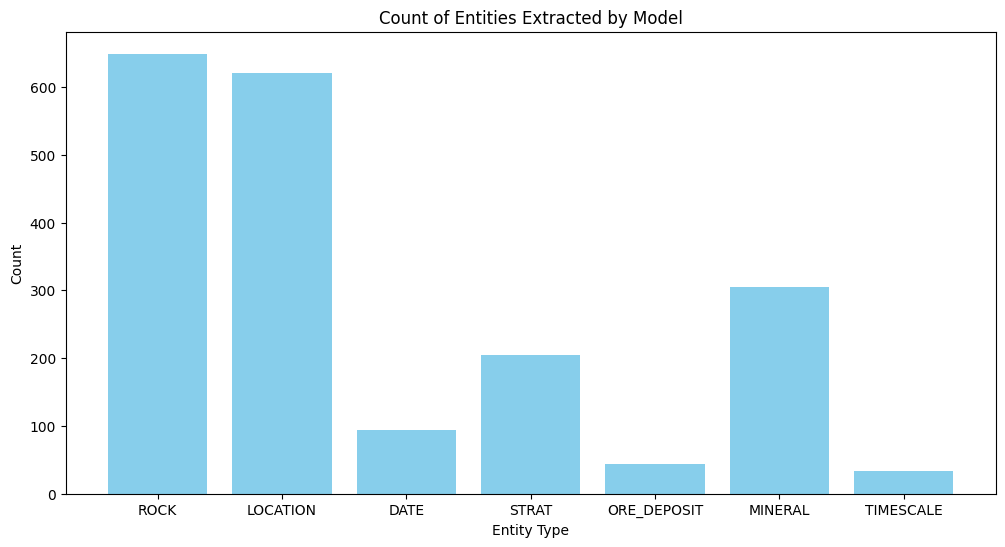

In [20]:
count_type = {"ROCK": 0, "LOCATION": 0, "DATE": 0, "STRAT": 0, "ORE_DEPOSIT": 0, "MINERAL": 0, "TIMESCALE": 0}


for triple in cleaned_model_kg:
    left_entity_type = triple[1].upper()
    right_entity_type = triple[4].upper()

    count_type[left_entity_type] += 1
    count_type[right_entity_type] += 1

entities_names = [entity for entity in count_type.keys()]
entities_values = [count for count in count_type.values()]

plt.figure(figsize=(12, 6))
plt.bar(entities_names, entities_values, color='skyblue')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.title('Count of Entities Extracted by Model')
# plt.xticks(rotation=45)
plt.show()

In [21]:
all_entities = []
for reports in all_tagged:
    for sentence in all_tagged[reports]:
        all_tagged[reports][sentence]["ner_cleaned"] = []
        # if all_tagged[reports][sentence]["ontology_cleaned"]:

        iob_tags = all_tagged[reports][sentence]["combined"].split()
        text = all_tagged[reports][sentence]["preprocess"].split()
        entities = get_entities(text, iob_tags) # Get unique entities

        all_entities.extend(entities)

print(all_entities)

total_entity_count = Counter([entity[1] for entity in all_entities])
print(total_entity_count)
# Unique entities extracted by the model
unique_entities = set(all_entities)
total_unique_entity_count = Counter([entity[1] for entity in unique_entities])
print(total_unique_entity_count)

[('Canning Highway Mt', 'Location'), ('June 2007', 'Date'), ('Eucalyptus Bore', 'Location'), ('Kookynie', 'Location'), ('Murrin Murrin mine', 'Location'), ('Kookynie', 'Location'), ('Mt', 'Location'), ('Yundamindra', 'Location'), ('Mount Burgess', 'Location'), ('Gold', 'Mineral'), ('ultramafic rocks', 'Rock'), ('silcrete', 'Rock'), ('laterite', 'Rock'), ('salt', 'Mineral'), ('kurrajong', 'Location'), ('June 2007 26', 'Date'), ('Glendenning', 'Location'), ('2002', 'Date'), ('former', 'Date'), ('gold', 'Mineral'), ('plastic', 'Rock'), ('plastic', 'Rock'), ('the time', 'Date'), ('for', 'Location'), ('Suite (', 'Location'), ('recent', 'Date'), ('Hepi', 'Location'), ('Mt Kilkenny', 'Location'), ('saprock', 'Rock'), ('clay', 'Rock'), ('Perth', 'Location'), ('clay', 'Rock'), ('saprock', 'Rock'), ('clay', 'Rock'), ('saprock', 'Rock'), ('gravels', 'Rock'), ('clay', 'Rock'), ('saprock', 'Rock'), ('saprock', 'Rock'), ('April 2007', 'Date'), ('June 2007', 'Date'), ('NiWest', 'Location'), ('2003', 

In [22]:

# Example list of triples in format: (head, head_type, relation, tail, tail_type)
def count_enitities(triples):
    # 1. Collect all entity types from head and tail
    entity_type_pairs = [(head_type, head) for head, head_type, _, _, _ in triples] + \
                        [(tail_type, tail) for _, _, _, tail, tail_type in triples]

    # 2. Count total occurrences per entity type
    total_entity_count = Counter(entity_type for entity_type, entity in entity_type_pairs)

    # 3. Count unique entities per entity type (using a set to avoid duplicates)
    unique_entity_count = Counter(entity_type for entity_type, entity in set(entity_type_pairs))

    # Output the results
    print("Total entity counts:")
    for entity_type, count in total_entity_count.items():
        print(f"{entity_type}: {count}")

    print("\nUnique entity counts:")
    for entity_type, count in unique_entity_count.items():
        print(f"{entity_type}: {count}")

    
def count_relations(triples):
    # 1. Count unique (head, relation, tail) combinations per relation
    unique_relation_count = Counter(relation for head, _, relation, tail, _ in set(triples))

    # 2. Count non-unique relations (all occurrences, including duplicates)
    non_unique_relation_count = Counter(relation for head, _, relation, tail, _ in triples)

    # Output the results
    print("Unique relation counts:")
    for relation, count in unique_relation_count.items():
        print(f"{relation}: {count}")

    print("\nNon-unique relation counts (including duplicates):")
    for relation, count in non_unique_relation_count.items():
        print(f"{relation}: {count}")
    print()

print("Final Model KG cleaned with ontology and NER:")
count_relations(cleaned_model_kg)

print("Ontology cleaned only KG - Benchmark using our own defined ontoloy:")
count_relations(ontology_cleaned_only_kg)

Final Model KG cleaned with ontology and NER:
Unique relation counts:
LocatedIn: 62
contains: 331
foundIn: 229
locatedNear: 116
hasAge: 34
isPartOf: 6
underlies: 9
foundAt: 89
overlies: 5

Non-unique relation counts (including duplicates):
locatedNear: 118
LocatedIn: 65
contains: 388
foundIn: 255
foundAt: 94
underlies: 10
isPartOf: 6
overlies: 6
hasAge: 34

Ontology cleaned only KG - Benchmark using our own defined ontoloy:
Unique relation counts:
contains: 3395
foundIn: 3060
hasAge: 412
foundAt: 1647
locatedNear: 821
LocatedIn: 346
underlies: 44
overlies: 45
isPartOf: 48

Non-unique relation counts (including duplicates):
foundAt: 1809
foundIn: 3310
locatedNear: 845
hasAge: 439
LocatedIn: 379
contains: 3863
underlies: 46
isPartOf: 53
overlies: 49



In [23]:
count_enitities(cleaned_model_kg)
count_enitities(ontology_cleaned_only_kg)

Total entity counts:
LOCATION: 621
ROCK: 649
MINERAL: 305
STRAT: 205
ORE_DEPOSIT: 44
DATE: 94
TIMESCALE: 34

Unique entity counts:
LOCATION: 250
MINERAL: 72
DATE: 59
ORE_DEPOSIT: 17
ROCK: 173
TIMESCALE: 19
STRAT: 63
Total entity counts:
ORE_DEPOSIT: 1191
LOCATION: 5758
ROCK: 7997
MINERAL: 3055
STRAT: 1337
DATE: 1809
TIMESCALE: 439

Unique entity counts:
LOCATION: 2073
ROCK: 1992
MINERAL: 525
ORE_DEPOSIT: 478
TIMESCALE: 268
STRAT: 401
DATE: 637


In [24]:
entity_list = ["ROCK", "LOCATION", "GEO_TIME", "DATE", "STRAT", "ORE_DEPOSIT", "MINERAL", "TIMESCALE"]

### Visualise KG into Neo4J

In [25]:
import openai
from typing import List
from neo4j import GraphDatabase
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

In [26]:
def create_nodes(tx, nodes):
    create_cypher = ""
    for i, (name, type) in enumerate(nodes):
        create_cypher += f"CREATE (:{type} {{name: \"{name}\"}})\n"
    tx.run(create_cypher)

def create_edges(tx, edges):
    for edge in edges:
        name1, type1 = edge[0], edge[1]
        name2, type2 = edge[3], edge[4]
        relation = edge[2]
        tx.run(f"MATCH (a:{type1} {{name: \"{name1}\"}}), (b:{type2} {{name: \"{name2}\"}}) CREATE (a)-[:{relation}]->(b)")

def get_entities(triples):
    entities = []
    for triple in triples:
        entities.append((triple[0], triple[1]))
        entities.append((triple[3], triple[4]))
    return list(set(entities))

entity_kg = get_entities(cleaned_model_kg)

driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))
print(entity_kg)
print(len(entity_kg))

# Run the query to create the nodes and edges in the graph in Neo4j
with driver.session() as session:
    session.run("MATCH (n) DETACH DELETE n")
    create_nodes(session, entity_kg)
    create_edges(session, cleaned_model_kg)

driver.close()

[('Eagle Nickel Ltd', 'LOCATION'), ('cumulate rock', 'ROCK'), ('mixed', 'ROCK'), ('Cue', 'LOCATION'), ('monzogranite', 'ROCK'), ('Isle Bore', 'LOCATION'), ('Kylena Basalts', 'STRAT'), ('siltstones', 'ROCK'), ('Earaheedy Basin', 'LOCATION'), ('1991', 'DATE'), ('alluvial gravels', 'ROCK'), ('late 1980s', 'DATE'), ('U3O8 Limiteds Wabli Creek project E09/1178', 'LOCATION'), ('Goldfields', 'LOCATION'), ('sandstone', 'ROCK'), ('crystals', 'MINERAL'), ('amphiboles', 'MINERAL'), ('opaline', 'MINERAL'), ('saprock', 'ROCK'), ('Mango Bore Project', 'LOCATION'), ('Mt Augustus-Paraburdoo Road', 'LOCATION'), ('Australia', 'LOCATION'), ('Wabli Creek project E09/1178', 'LOCATION'), ('Wyloo', 'LOCATION'), ('1988', 'DATE'), ('amphibolite', 'ROCK'), ('Aurora', 'LOCATION'), ('ultramafic rock', 'ROCK'), ('Mount Farmer Group', 'STRAT'), ('Murrin Murrin Two Deposit', 'LOCATION'), ('Burmeister Syncline', 'LOCATION'), ('Singleton', 'LOCATION'), ('Eucalyptus Bore', 'LOCATION'), ('silcrete', 'ROCK'), ('Fairbairn

### QA Rag

In [27]:
# Extract entities from text
# https://neo4j.com/developer-blog/enhance-rag-knowledge-graph/
# https://github.com/tomasonjo/blogs/blob/master/llm/enhancing_rag_with_graph.ipynb
os.environ["OPENAI_API_KEY"] = api_key
llm=ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person, organization, or business entities that "
        "appear in the text",
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization and person entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {question}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

In [28]:
driver = GraphDatabase.driver(URI, auth=(USER,PASSWORD))

openai.api_key = api_key
client = OpenAI(api_key=api_key)

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [record for record in result]

def get_triples(keyword):
    query = f"""
        MATCH (n)-[r]->(m)
        WHERE n.name CONTAINS '{keyword}' OR m.name CONTAINS '{keyword}'
        RETURN n.name AS subject, type(r) AS predicate, m.name AS object
    """
    results = run_query(query)
    triples = [(record['subject'], record['predicate'], record['object']) for record in results]
    return triples

def query_llm(triples, question):
    # Format the triples as text for LLM input
    triples_text = "\n".join([f"{s} --{p}--> {o}" for s, p, o in triples])
    prompt = f"""Answer the question based only on the following context:
{triples_text}

Question: {question}
Use natural language and be concise.
Answer:"""
    

    # Send request to OpenAI LLM
    response = client.chat.completions.create(
        model='gpt-4o-mini',  # You can choose a different model
        temperature=0,
        messages=[
            {"role": "user", "content": prompt}
            ])
    
    answer = response.choices[0].message.content.strip()
    return answer

def QARag(question):
    # Extract keywords from the question (simple example)

    keywords = entity_chain.invoke({"question": question}).names
    print(keywords)
    # Get triples for each keyword
    all_triples = []
    for keyword in keywords:
        triples = get_triples(keyword)
        all_triples.extend(triples)
    print(all_triples)
    # Query LLM with the collected triples
    answer = query_llm(all_triples, question)
    print(f"Question: {question}")
    print(f"Answer: {answer}")


sample_question = "Where is clay and gold found in?"
QARag(sample_question)

# Close the driver
driver.close()


['clay', 'gold']
[('saprock', 'contains', 'clay'), ('laterite', 'contains', 'clays'), ('laterite', 'contains', 'clays'), ('laterite', 'contains', 'clays'), ('laterite', 'contains', 'clays'), ('laterite', 'contains', 'clays'), ('granite', 'contains', 'clays'), ('clay', 'foundIn', 'Hepi'), ('clay', 'foundIn', 'Fortescue River'), ('clay', 'foundIn', 'Mt Kilkenny'), ('clay', 'contains', 'iron'), ('clay', 'contains', 'kaolinitic clay'), ('clay', 'contains', 'smectite'), ('clay', 'contains', 'high clay content'), ('clay', 'contains', 'clays'), ('clay', 'contains', 'shales'), ('clay', 'contains', 'aluminium'), ('clays', 'foundIn', 'Sullivan'), ('clays', 'foundIn', 'Chrysoprase Pit'), ('clays', 'foundIn', 'Eucalyptus'), ('clays', 'contains', 'oxides'), ('clays', 'contains', 'mafics'), ('clays', 'contains', 'vanadium'), ('clays', 'contains', 'chlorite'), ('clays', 'contains', 'magnesite'), ('clays', 'contains', 'smectite'), ('clays', 'contains', 'serpentinite'), ('clays', 'contains', 'serpentin